In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [22]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod3(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual3(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod3(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]


def residual_p_cygni(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    intensity = temp(wav, T)
    v_out=vmax
    v_phot = vphot
    occul=occult2
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    intensity = N*intensity*(correction-1)
    
    if data is None:
        return intensity
    return (model - data)/error

def bb(wav, T, N):
    wav = wav
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

In [23]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
wl2, flux2, error2 = wl, flux, error # bin_spectrum(wl, flux, error, ~exc_reg_2, 10)


pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb")
emcee_res3 = pickle.load(pickle_in)
flux_fit = residual3(emcee_res3.params, wl2*1e-10)

np.mean((flux2-flux_fit)**2/error2**2)

C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]


2.267117096342701

In [24]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[1]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
wl2, flux2, error2 = wl, flux, error # bin_spectrum(wl, flux, error, ~exc_reg_2, 10)


pickle_in = open("./data/OB2/OB2_3_peaks_with_gaussian_1.pkl","rb")
emcee_res3 = pickle.load(pickle_in)
flux_fit = residual3(emcee_res3.params, wl2*1e-10)

np.mean((flux2-flux_fit)**2/error2**2)

C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]


1.6754208854893504

In [25]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[2]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
wl2, flux2, error2 = wl, flux, error # bin_spectrum(wl, flux, error, ~exc_reg_2, 10)


pickle_in = open("./data/OB3/OB3_3_peaks_with_gaussian.pkl","rb")
emcee_res3 = pickle.load(pickle_in)
flux_fit = residual3(emcee_res3.params, wl2*1e-10)

np.mean((flux2-flux_fit)**2/error2**2)

1.7156829753907519

In [75]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[3]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
wl4, flux4, error4 = wl, flux, error # bin_spectrum(wl, flux, error, ~exc_reg_2, 10)


pickle_in = open("./data/OB4/OB4_3_peaks_with_gaussian.pkl","rb")
emcee_res3 = pickle.load(pickle_in)
flux_fit = residual3(emcee_res3.params, wl4*1e-10)
error4 = error4*np.sqrt(1.67)

np.mean((flux4-flux_fit)**2/error4**2)

1.0033490285826077

In [76]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[4]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
wl5, flux5, error5 = wl, flux, error # bin_spectrum(wl, flux, error, ~exc_reg_2, 10)


pickle_in = open("./data/OB5/OB5_3_peaks_with_gaussian.pkl","rb")
emcee_res3 = pickle.load(pickle_in)
flux_fit = residual3(emcee_res3.params, wl5*1e-10)
error5 = error5*np.sqrt(1.95)

np.mean((flux5-flux_fit)**2/error5**2)

1.0021991935657175

In [109]:
def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl4*1e-10)
    return lnprob_inner(model, flux4, error4)

pickle_in = open("./data/OB4/OB4_two_Pcygni_28x5000.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

mini = lmfit.Minimizer(lnprob, p)
nwalkers = 200 
res4_1 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2500, thin=1, params=p, seed=1, workers = 4)

print('Time elapsed [hours]:',(end-start)/60/60 )

100%|██████████| 2500/2500 [3:49:28<00:00,  5.51s/it]  


The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [128.88361035 130.07989323 134.94155229 139.32975956 145.96976406
 172.27594961 142.48917562 137.53746826 137.45225863 141.11495401
 140.32629798 181.32969344 139.5889001  219.7625896 ]
Time elapsed [hours]: 3.6923986722363367


(7506.464505369125, 8.856170784411006, 9.551664033541783)

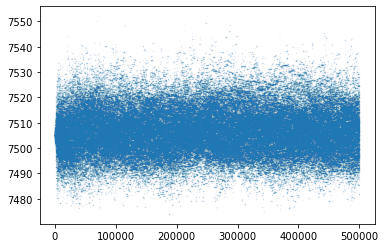

In [111]:
plt.scatter(np.arange(len(res4_1.flatchain['lambda_n'])), res4_1.flatchain['lambda_n'], s=0.1, alpha=0.1)

med, l, h = np.median(res4_1.flatchain['lambda_n'][:]), np.percentile(res4_1.flatchain['lambda_n'][:], 15.9), np.percentile(res4_1.flatchain['lambda_n'][:], 100-15.9)

med, med-l, h-med


(7505.882994004119, 9.327133361270171, 9.719326443557293)

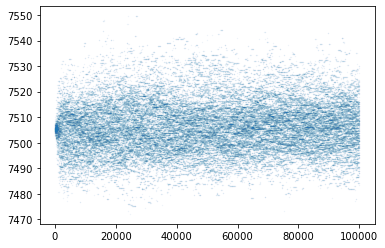

In [78]:
plt.scatter(np.arange(len(res4.flatchain['lambda_n'])), res4.flatchain['lambda_n'], s=0.1, alpha=0.1)

med, l, h = np.median(res4.flatchain['lambda_n'][:]), np.percentile(res4.flatchain['lambda_n'][:], 15.9), np.percentile(res4.flatchain['lambda_n'][:], 100-15.9)

med, med-l, h-med


In [116]:
res4_1.params

name,value,standard error,relative error,initial value,min,max,vary
T,3233.15581,1.64729253,(0.05%),3234.3962625116383,2500.00000,7500.00000,True
N,3.1242e-29,8.6405e-32,(0.28%),3.120739634650253e-29,-inf,inf,True
vphot,0.17633126,0.00105945,(0.60%),0.17656698606872984,0.00000000,1.00000000,True
vmax,0.23100437,6.3961e-04,(0.28%),0.23116715937497467,0.00000000,1.00000000,True
t0,385200.000,,(0.28%),385200,-inf,inf,False
tau,0.38078041,0.00839126,(2.20%),0.3851950743930552,0.00000000,10.0000000,True
vref,0.00000000,,(2.20%),0.0,0.00000000,1.00000000,False
ve,12.1797593,4.75959543,(39.08%),10.769461133136815,0.00000000,20.0000000,True
occult,7.77784665,0.10087315,(1.30%),7.713599721736371,0.10000000,20.0000000,True
amp1,0.96374711,0.00615141,(0.64%),0.9638186217705084,0.01000000,5.00000000,True


In [117]:
res5_1.params

name,value,standard error,relative error,initial value,min,max,vary
T,3112.32791,3.54704952,(0.11%),3109.64173683202,2500.00000,7500.00000,True
N,3.4244e-29,2.0092e-31,(0.59%),3.460167090225695e-29,-inf,inf,True
vphot,0.15571140,0.00170563,(1.10%),0.15210905777309286,0.00000000,1.00000000,True
vmax,0.24921643,0.00268507,(1.08%),0.24344816014409126,0.00000000,1.00000000,True
t0,466560.000,,(1.08%),466560,-inf,inf,False
tau,0.29780763,0.02593318,(8.71%),0.3033199327015409,0.00000000,10.0000000,True
vref,0.00000000,,(8.71%),0.0,0.00000000,1.00000000,False
ve,0.19958926,0.01744850,(8.74%),0.19687569837526733,0.00000000,20.0000000,True
occult,19.7797044,0.25506633,(1.29%),19.052686215359216,0.10000000,20.0000000,True
amp1,1.21815113,0.00953757,(0.78%),1.1859577659119578,0.01000000,5.00000000,True


In [110]:
def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl5*1e-10)
    return lnprob_inner(model, flux5, error5)

pickle_in = open("./data/OB5/OB5_two_Pcygni_30x2000_lambda0free_7685.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

mini = lmfit.Minimizer(lnprob, p)
nwalkers = 200 
res5_1 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2500, thin=1, params=p, seed=1, workers = 4)

print('Time elapsed [hours]:',(end-start)/60/60 )

100%|██████████| 2500/2500 [3:31:47<00:00,  5.08s/it]  


The chain is shorter than 50 times the integrated autocorrelation time for 15 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [221.37749744 219.72807262 199.0015036  196.55797102 274.42747805
 280.79539912 219.76382821 215.12341079 230.18562751 259.44904937
 283.00839007 325.17514141 178.44165915 296.20840784 285.03443586]
Time elapsed [hours]: 3.6923986722363367


(7699.415676629099, 16.23995524770453, 20.33039069447841)

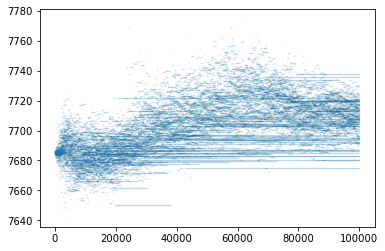

In [80]:
plt.scatter(np.arange(len(res5.flatchain['lambda_n'])), res5.flatchain['lambda_n'], s=0.1, alpha=0.1)

med, l, h = np.median(res5.flatchain['lambda_n'][:]), np.percentile(res5.flatchain['lambda_n'][:], 15.9), np.percentile(res5.flatchain['lambda_n'][:], 100-15.9)

med, med-l, h-med


(7702.155093643299, 12.713430734246685, 11.89336843052024)

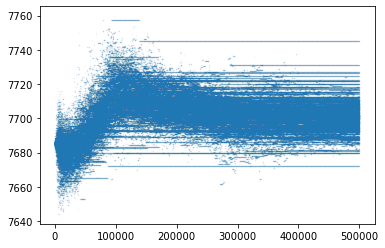

In [112]:
plt.scatter(np.arange(len(res5_1.flatchain['lambda_n'])), res5_1.flatchain['lambda_n'], s=0.1, alpha=0.1)

med, l, h = np.median(res5_1.flatchain['lambda_n'][:]), np.percentile(res5_1.flatchain['lambda_n'][:], 15.9), np.percentile(res5_1.flatchain['lambda_n'][:], 100-15.9)

med, med-l, h-med


In [93]:
195/np.sqrt(20**2+10**2)

8.72066511224918

In [113]:
#with open("./Data/OB5/OB5_two_Pcygni_200x2500_lambda0free_7700.pkl", 'wb') as outfile:
#    pickle.dump(res5_1, outfile)
    
#with open("./Data/OB4/OB4_two_Pcygni_200x2500_lambda0free_7505.pkl", 'wb') as outfile:
#    pickle.dump(res4_1, outfile)

In [47]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, 
                    v_out_n=0.2, v_phot_n=0.1, tau_n=0.2, lambda_n=7500, ve_n=0.1
                   
                   ): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)

    pcyg_prof_n = p_cygni_line_corr(wav, v_out_n, v_phot_n, tau_n   , lambda_n, vref=vref, ve=ve_n , t0=t0)

    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction * pcyg_prof_n
    return N*intensity+gau1+gau2

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]


def residual_p_cygni(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    intensity = temp(wav, T)
    v_out=vmax
    v_phot = vphot
    occul=occult2
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    intensity = N*intensity*(correction-1)
    
    if data is None:
        return intensity
    return (model - data)/error

def bb(wav, T, N):
    wav = wav
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

In [48]:
def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2 = v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    v_out_n, v_phot_n, tau_n, lambda_n, ve_n = v["v_out_n"], v["v_phot_n"], v["tau_n"], v["lambda_n"], v["ve_n"]
    
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, 
                           v_out_n=v_out_n, v_phot_n=v_phot_n, tau_n=tau_n, lambda_n=lambda_n, ve_n=ve_n)
    
    if data is None:
        return model
    return (model - data)/error

def residual2(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T2"], v["N2"], v["vphot2"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax2"], v["tau2"], v["vref"], v["ve2"], v["occult2"]
    amp1, amp2, cen1, cen2, sig1, sig2 = v["amp1_2"], v["amp2_2"], v["cen1"], v["cen2"], v["sig1_2"], v["sig2_2"]

    v_out_n, v_phot_n, tau_n, lambda_n, ve_n = v["v_out_n_2"], v["v_phot_n_2"], v["tau_n_2"], v["lambda_n"], v["ve_n_2"]
    
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, 
                           v_out_n=v_out_n, v_phot_n=v_phot_n, tau_n=tau_n, lambda_n=lambda_n, ve_n=ve_n)
    
    if data is None:
        return model
    return (model - data)/error

In [49]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

In [50]:
pickle_in = open("./data/OB4/OB4_two_Pcygni_28x5000.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

In [51]:
pickle_in = open("./data/OB5/OB5_two_Pcygni_30x2000_lambda0free_7685.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

In [52]:
pickle_in = open("./data/OB4/OB4_two_Pcygni_28x5000.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

p = emcee_res.params
p.add('T2', value=3109, min=1000, max=5000)
p.add('N2', value=3.46e-29)#, min=-np.inf, max=1)
p.add('vphot2', value= 0.152, min=0, max=1)
p.add('vmax2', value= 0.243 , min=0, max=1)
p.add('tau2', value=0.3, min=0, max=10)
p.add('ve2', value=0.20, min=0, max=10)
p.add('occult2', value=19, min=0, max=30)
p.add('amp1_2', value= 1.18, min=0, max=2)
p.add('amp2_2', value= 1.32, min=0, max=2)
#p.add('cen1_2', value= 1.5168e-06 , min= 1.4000e-06 , max= 1.7000e-06 )
#p.add('cen2_2', value= 1.9006e-06 , min= 1.8000e-06 , max= 2.2000e-06 )
p.add('sig1_2', value=  7.2600e-08  , min= 1.0000e-08 , max= 3.0000e-07 )
p.add('sig2_2', value=  1.6200e-07  , min= 1.0000e-08 , max= 3.0000e-07 )

p.add('v_out_n_2' , value= 0.19 , min= 0 , max= 1 )
p.add('v_phot_n_2', value= 0.1656 , min= 0 , max= 1 )
p.add('tau_n_2', value= 1.29 , min= 0 , max= 10 )
p.add('ve_n_2'   , value=  0.67251403  , min= 0 , max= 10 )
p.add('occul_n_2', value=  0.64919133  , min= 0 , max= 3 )

#p['cen2'].min = 1.8e-6


#p['lam0'].value = 10456
#p['lam0'].vary = False
p

name,value,standard error,relative error,initial value,min,max,vary
T,3234.39626,1.27628420,(0.04%),3233.5476586044224,2500.00000,7500.00000,True
N,3.1207e-29,6.4594e-32,(0.21%),3.125331180153125e-29,-inf,inf,True
vphot,0.17656699,9.7235e-04,(0.55%),0.17745336951167534,0.00000000,1.00000000,True
vmax,0.23116716,5.2905e-04,(0.23%),0.2314336528942482,0.00000000,1.00000000,True
t0,385200.000,,(0.23%),385200,-inf,inf,False
tau,0.38519507,0.00857821,(2.23%),0.39737878942341115,0.00000000,10.0000000,True
vref,0.00000000,,(2.23%),0.0,0.00000000,1.00000000,False
ve,10.7694611,5.33037225,(49.50%),6.4211246169814595,0.00000000,20.0000000,True
occult,7.71359972,0.07775529,(1.01%),7.686298468148233,0.10000000,20.0000000,True
amp1,0.96381862,0.00468924,(0.49%),0.9602415026419951,0.01000000,5.00000000,True


In [104]:
pickle_in = open("./Data/750_OB4+OB5_lam_fix_7600_long.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['cen2'].min = 1.8e-6


#p['lambda_n'].value = 7600
p['lambda_n'].vary = True
p

name,value,standard error,relative error,initial value,min,max,vary
T,3237.12359,2.08829155,(0.06%),3236.9774343479285,2500.00000,7500.00000,True
N,3.1115e-29,1.1301e-31,(0.36%),3.1119571112769496e-29,-inf,inf,True
vphot,0.18847325,0.00137778,(0.73%),0.1896530011300581,0.00000000,1.00000000,True
vmax,0.23632872,7.1865e-04,(0.30%),0.23613877720694243,0.00000000,1.00000000,True
t0,385200.000,,(0.30%),385200,-inf,inf,False
tau,0.47630574,0.01685145,(3.54%),0.4915160734061014,0.00000000,10.0000000,True
vref,0.00000000,,(3.54%),0.0,0.00000000,1.00000000,False
ve,4.42846814,1.81044592,(40.88%),10.361539508986638,0.00000000,20.0000000,True
occult,7.69841471,0.14884682,(1.93%),7.252805111511586,0.10000000,20.0000000,True
amp1,0.96546110,0.00765479,(0.79%),0.9709241909503424,0.01000000,5.00000000,True


In [105]:
def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl4*1e-10)
    model2 = residual2(pars, wl5*1e-10)
    return lnprob_inner(model, flux4, error4) + lnprob_inner(model2, flux5, error5)

mini = lmfit.Minimizer(lnprob, p)

start = time.time()
nwalkers = 100 #v = p.valuesdict()
res8 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2000, thin=1, params=p, seed=1, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]
C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]
C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The algorithm does not con

The chain is shorter than 50 times the integrated autocorrelation time for 30 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [217.65135287 210.41428221 195.00792665 264.79510867 172.06051518
 247.82467688 258.24019358 184.1387702  167.45880814 264.31268514
 259.5847338  246.93557051 276.90641942 228.56318063 254.81645754
 254.4462084  243.26906378 246.5063972  260.63130121 243.02796788
 266.4665306  241.34505509 251.93485705 219.90266893 240.62535973
 255.0778833  252.42943743 253.86308059 229.67833305 172.20227726]
Time elapsed [hours]: 3.6923986722363367


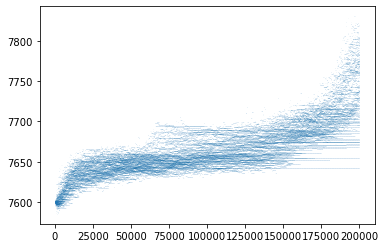

In [107]:
plt.scatter(np.arange(len(res8.flatchain['vphot'])), res8.flatchain['lambda_n'], s=0.01, alpha=0.1)


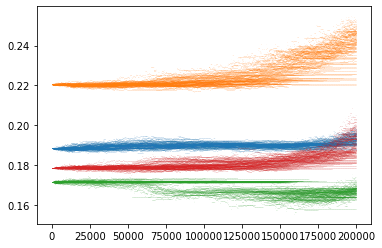

In [108]:
plt.scatter(np.arange(len(res8.flatchain['vphot'])), res8.flatchain['vphot'], s=0.01, alpha=0.1)
plt.scatter(np.arange(len(res8.flatchain['vphot'])), res8.flatchain['v_phot_n'], s=0.01, alpha=0.1)

plt.scatter(np.arange(len(res8.flatchain['vphot'])), res8.flatchain['vphot2'], s=0.01, alpha=0.1)
plt.scatter(np.arange(len(res8.flatchain['vphot'])), res8.flatchain['v_phot_n_2'], s=0.01, alpha=0.1)

In [99]:
res7.flatchain

,T,N,vphot,vmax,tau,ve,occult,amp1,amp2,v_out_n,...,occult2,amp1_2,amp2_2,sig1_2,sig2_2,v_out_n_2,v_phot_n_2,tau_n_2,ve_n_2,occul_n_2
0,3237.614529,3.111500e-29,0.189640,0.236115,0.491595,10.358550,7.254956,0.970795,0.928298,0.249784,...,23.116343,1.231948,1.355036,7.771036e-08,1.648480e-07,0.200493,0.179009,2.022059,1.065090,0.556030
1,3237.149109,3.111742e-29,0.189645,0.236123,0.491475,10.360844,7.252796,0.970816,0.928263,0.249831,...,23.114603,1.232085,1.354960,7.769913e-08,1.648118e-07,0.200477,0.179026,2.022242,1.065292,0.556104
2,3237.281416,3.112535e-29,0.189623,0.236199,0.491534,10.361184,7.252774,0.970911,0.928489,0.249889,...,23.121879,1.232113,1.355168,7.769973e-08,1.648158e-07,0.200502,0.179041,2.022419,1.065221,0.555951
3,3237.065028,3.111995e-29,0.189681,0.236169,0.491524,10.361008,7.252081,0.970962,0.928252,0.249774,...,23.116683,1.231852,1.354921,7.770183e-08,1.648057e-07,0.200488,0.179051,2.021831,1.065230,0.555979
4,3236.955140,3.111428e-29,0.189676,0.236149,0.491513,10.360762,7.253814,0.971125,0.928054,0.249820,...,23.112691,1.232070,1.354750,7.770919e-08,1.648310e-07,0.200480,0.179028,2.022323,1.065289,0.556085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,3234.794345,3.123932e-29,0.189356,0.236504,0.490018,4.342672,7.666020,0.954244,0.921171,0.245311,...,29.061763,1.245955,1.362612,7.822765e-08,1.645942e-07,0.202750,0.182203,2.593596,1.665360,0.446445
599996,3237.991716,3.105803e-29,0.187388,0.235500,0.470174,4.755025,7.816982,0.975985,0.922315,0.235116,...,28.948947,1.248893,1.355041,7.609555e-08,1.655773e-07,0.197944,0.177758,2.502196,1.754564,0.457301
599997,3237.275080,3.112367e-29,0.187735,0.236495,0.462058,5.944027,7.624675,0.961154,0.916457,0.244291,...,29.902201,1.264942,1.365136,7.827645e-08,1.644390e-07,0.202485,0.182041,3.040070,1.319720,0.496920
599998,3241.381939,3.090019e-29,0.189211,0.236898,0.489167,4.589387,7.629786,0.980043,0.930611,0.246144,...,28.538111,1.228001,1.357935,7.866679e-08,1.633853e-07,0.196841,0.176799,2.341548,1.734075,0.474632


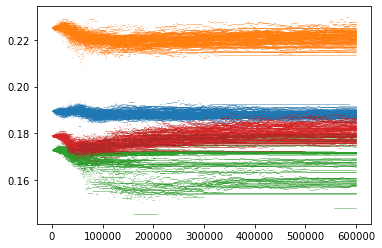

In [101]:
plt.scatter(np.arange(len(res7.flatchain['vphot'])), res7.flatchain['vphot'], s=0.01, alpha=0.1)
plt.scatter(np.arange(len(res7.flatchain['vphot'])), res7.flatchain['v_phot_n'], s=0.01, alpha=0.1)

plt.scatter(np.arange(len(res7.flatchain['vphot'])), res7.flatchain['vphot2'], s=0.01, alpha=0.1)
plt.scatter(np.arange(len(res7.flatchain['vphot'])), res7.flatchain['v_phot_n_2'], s=0.01, alpha=0.1)

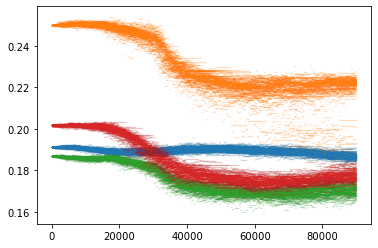

In [92]:
plt.scatter(np.arange(len(res6.flatchain['vphot'])), res6.flatchain['vphot'], s=0.1, alpha=0.1)
plt.scatter(np.arange(len(res6.flatchain['vphot'])), res6.flatchain['v_phot_n'], s=0.1, alpha=0.1)

plt.scatter(np.arange(len(res6.flatchain['vphot'])), res6.flatchain['vphot2'], s=0.1, alpha=0.1)
plt.scatter(np.arange(len(res6.flatchain['vphot'])), res6.flatchain['v_phot_n_2'], s=0.1, alpha=0.1)

In [103]:
with open("./Data/750_OB4+OB5_lam_fix_7600_long.pkl", 'wb') as outfile:
    pickle.dump(res7, outfile)

(7827.1509931600385, 41.59543321853471, 28.97230363576)

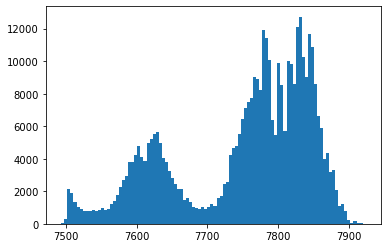

In [69]:
plt.hist(res3.flatchain['lambda_n'], bins=100); 
med, l, h = np.median(res3.flatchain['lambda_n'][200000:]), np.percentile(res3.flatchain['lambda_n'][200000:], 15.9), np.percentile(res3.flatchain['lambda_n'][200000:], 100-15.9)

med, med-l, h-med

In [67]:
#with open("./Data/750_OB4+OB5_lam7780.pkl", 'wb') as outfile:
#    pickle.dump(res3, outfile)

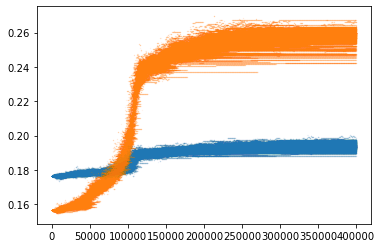

In [71]:
plt.scatter(np.arange(len(res3.flatchain['lambda_n'])), res3.flatchain['vphot'], s=0.1, alpha=0.1)
plt.scatter(np.arange(len(res3.flatchain['lambda_n'])), res3.flatchain['v_phot_n'], s=0.1, alpha=0.1)

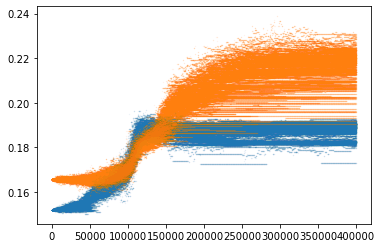

In [72]:
plt.scatter(np.arange(len(res3.flatchain['lambda_n'])), res3.flatchain['vphot2'], s=0.1, alpha=0.1)
plt.scatter(np.arange(len(res3.flatchain['lambda_n'])), res3.flatchain['v_phot_n_2'], s=0.1, alpha=0.1)

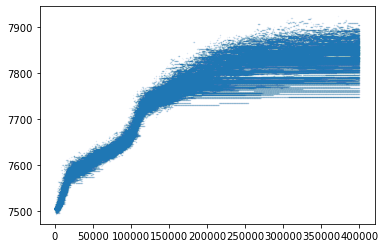

In [62]:
plt.scatter(np.arange(len(res3.flatchain['lambda_n'])), res3.flatchain['lambda_n'], s=0.1, alpha=0.1)

(array([ 3870.,  4009.,  3058.,  3186.,  4459.,  9323., 15231., 12572.,
         4149.,   143.]),
 array([7493.42050222, 7509.28243943, 7525.14437664, 7541.00631386,
        7556.86825107, 7572.73018828, 7588.5921255 , 7604.45406271,
        7620.31599992, 7636.17793714, 7652.03987435]),
 <BarContainer object of 10 artists>)

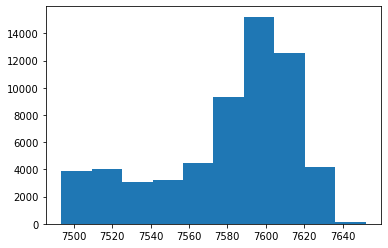

In [56]:
plt.hist(res2.flatchain['lambda_n'], bins=100)

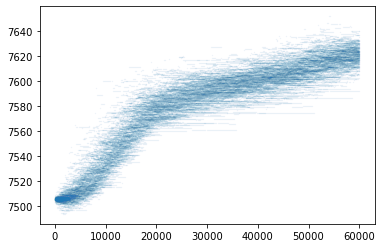

In [59]:
plt.scatter(np.arange(len(res2.flatchain['lambda_n'])), res2.flatchain['lambda_n'], s=0.1, alpha=0.1)

In [121]:
1.88*0.7, 1.65*0.7

(1.3159999999999998, 1.1549999999999998)